**Import bibliotek + import bazy danych**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

**Import danych z pliku csv i podzia≈Ç danych na grupƒô: cechy oraz target**

In [2]:
diabetes = pd.read_csv('diabetes.csv')

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

**Podzia≈Ç danych na zbi√≥r treningowy oraz zbi√≥r testowy + standaryzacja zbior√≥w**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies', 'Age']], y, test_size=0.30, random_state=0, stratify=y)

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train) 
X_test_standardized = scaler_2var.transform(X_test)

# Przypomnienie dlaczego fit_transform dla X_train, a dla X_test samo transform:
# "Uczymy" jak transormowaƒá na bazie zbioru treningowego i na podstawie ju≈º wytrenowanego scalera w ten sam spos√≥b skalujemy X_test.

**Zdefiniowanie funkcji: plot_classification_surface:**

In [4]:
def generate_model_LR(penalty,C):
    if penalty == "l1":
        model = LogisticRegression(penalty=penalty,C=C,solver='liblinear')
    elif penalty == "l2":
        model = LogisticRegression(penalty=penalty,C=C)
    elif penalty == "elasticnet":
        model = LogisticRegression(penalty=penalty,C=C,solver='saga', l1_ratio=0.1)
    else:
        raise ValueError("Nieprawid≈Çowa warto≈õƒá 'penalty'")
    
    return model

**Zdefiniowanie funkcji: plot_classification_surface:**

In [5]:
def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    xx, yy = meshgrid(x1grid, x2grid)

    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    grid = hstack((r1,r2))

    yhat = trained_model.predict(grid)

    zz = yhat.reshape(xx.shape)

    plt.contourf(xx, yy, zz, cmap='Paired')

    for class_value in range(2):

        row_ix = where(y_plot == class_value)
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)

    plt.legend(loc='upper right')
    plt.show()

**Zdefiniowanie funkcji calculate_metrics_new:**

In [6]:
metrics_dataframe = pd.DataFrame(columns=[
    'Model', 'Penalty', 'Par_C','F1_train',
    'F1_test', 'AUC_test', 'Accuracy_test', 'Precision_test', 'Recall_test'
])

def calculate_metrics_new(model, name, X_test, y_test, X_train, y_train):
    global metrics_dataframe
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    predictions_proba = model.predict_proba(X_test)[:, 1]

    try:
        name_title = f"{name}"
        penalty = model.get_params()['penalty']
        C_value = model.get_params()['C']
    except:
        penalty = "UNKNOWN"
        C_value = "UNKNOWN"    
    
    print(f"\n Model: {name_title} - penalty:{penalty}, parametr C:{C_value}")
   
    plot_classification_surface(X_train, y_train, model)
    
    f1_metric_train = round(f1_score(y_train, predictions_train),4)
    f1_metric_test = round(f1_score(y_test, predictions_test),4)
    auc_metric = round(roc_auc_score(y_test, predictions_proba),4)
    acc_metric = round(accuracy_score(y_test, predictions_test),4)
    prec_metric = round(precision_score(y_test, predictions_test),4)
    rec_metric = round(recall_score(y_test, predictions_test),4)

    new_row = pd.DataFrame([{
        'Model': name,
        'Penalty': penalty,
        'Par_C': C_value,
        'F1_train': f1_metric_train,
        'F1_test': f1_metric_test,
        'AUC_test': auc_metric,
        'Accuracy_test': acc_metric,
        'Precision_test': prec_metric,
        'Recall_test': rec_metric
    }])

    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

**Zdefiniowanie zbior√≥w parametr√≥w: "penalties" i "parametrs_C"**

In [7]:
penalties = ['l1', 'l2', 'elasticnet']
parametrs_C = [0.01, 0.1, 1, 10, 100]

**Uruchomienie pƒôtli generujƒÖcej, trenujƒÖcej modele oraz wy≈õwietlajƒÖcej zbi√≥r metryk wygenerownych modeli**


 Model: Logistic Regression - penalty:l1, parametr C:0.01


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


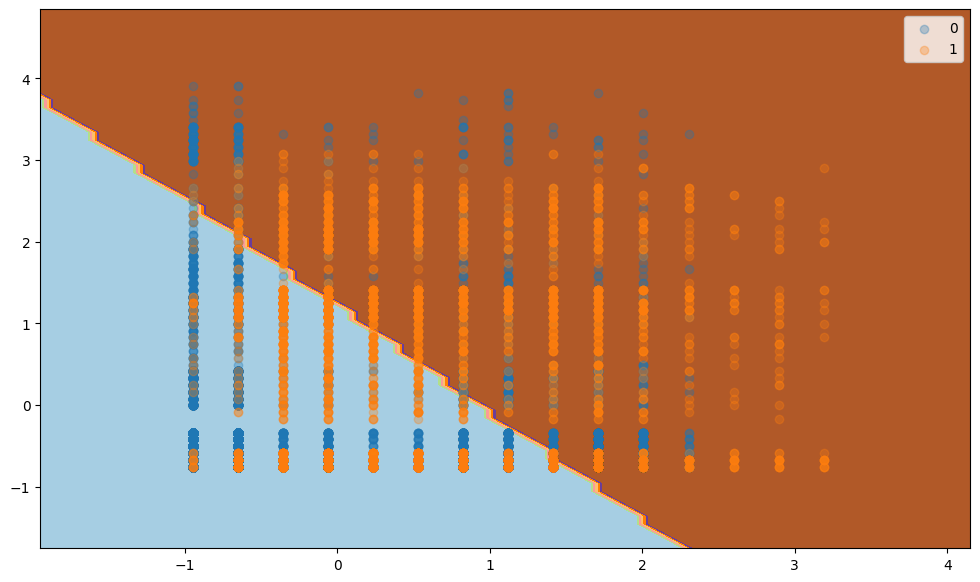

C:\Users\marci\AppData\Local\Temp\ipykernel_26632\137192969.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)



 Model: Logistic Regression - penalty:l1, parametr C:0.1


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


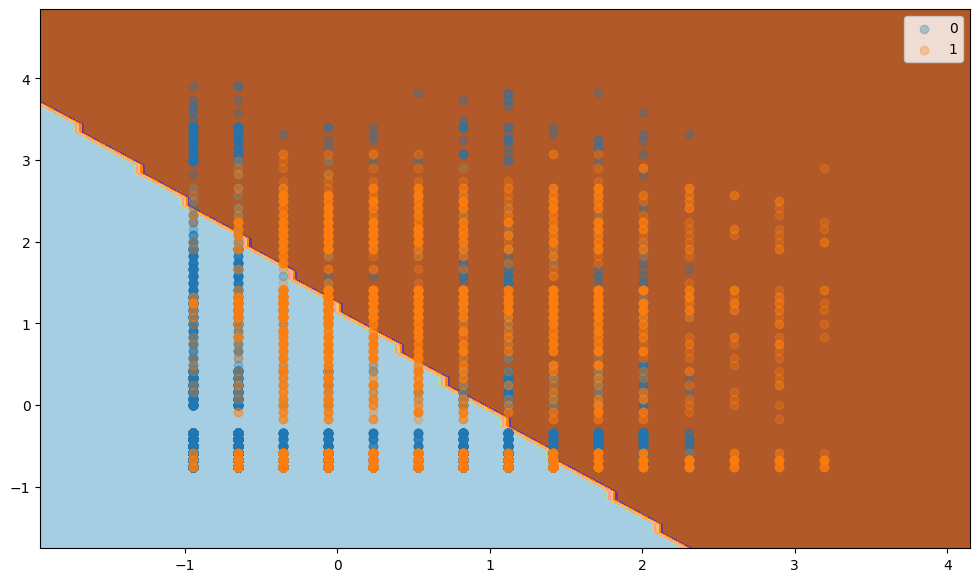

C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)



 Model: Logistic Regression - penalty:l1, parametr C:1


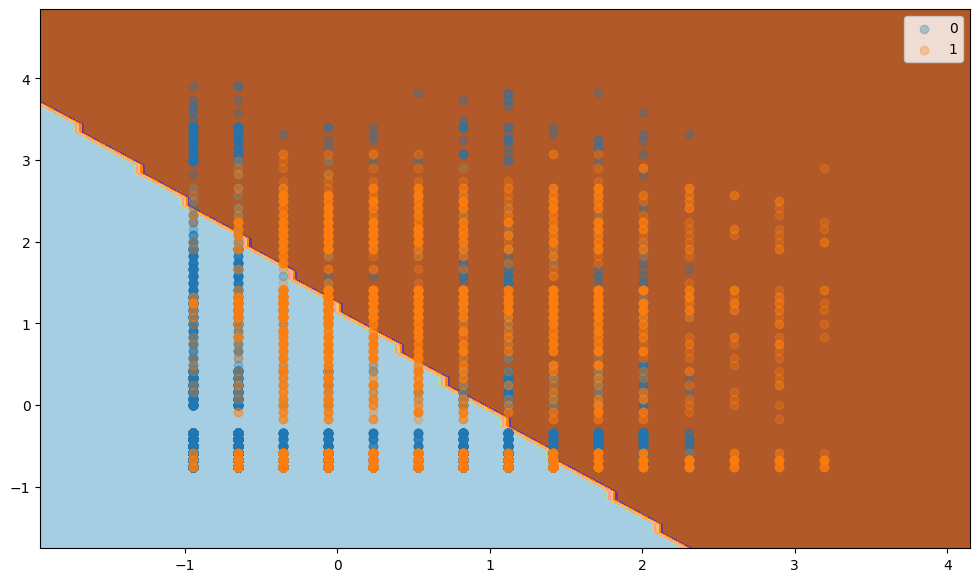


 Model: Logistic Regression - penalty:l1, parametr C:10


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


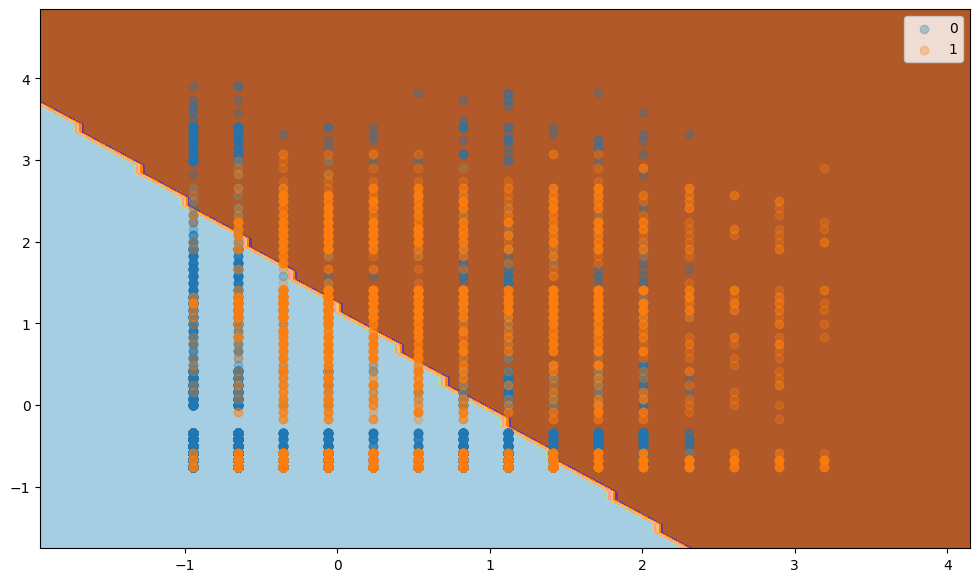


 Model: Logistic Regression - penalty:l1, parametr C:100


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


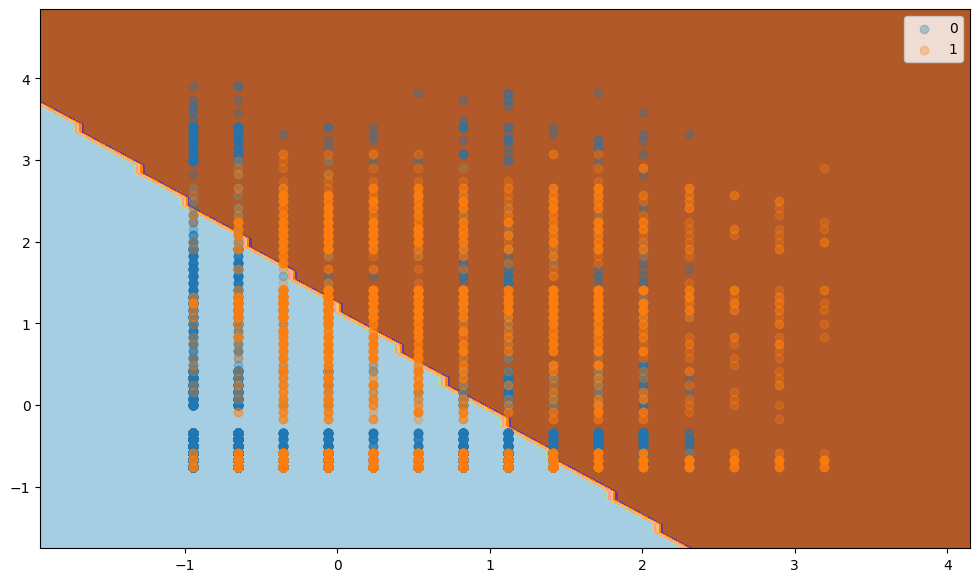


 Model: Logistic Regression - penalty:l2, parametr C:0.01


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


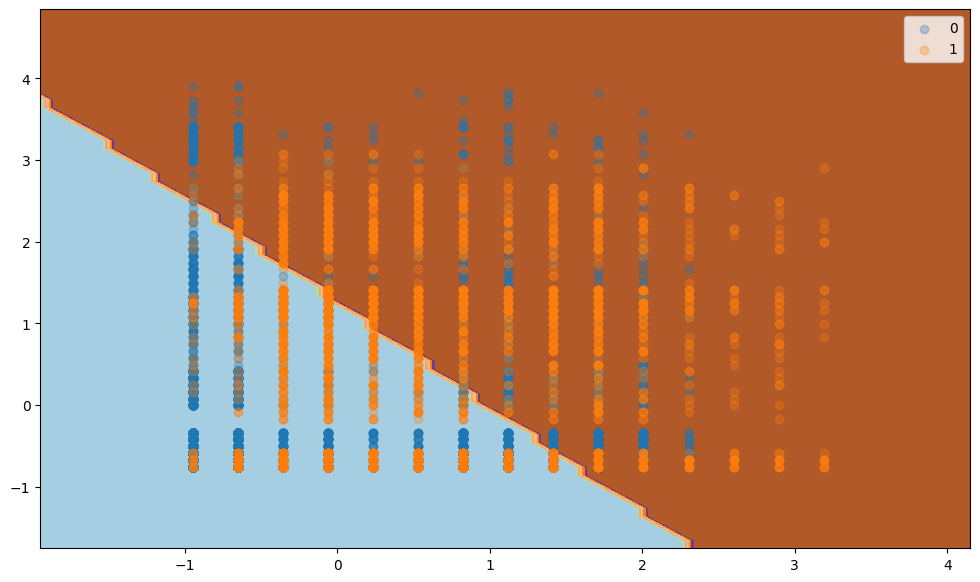


 Model: Logistic Regression - penalty:l2, parametr C:0.1


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


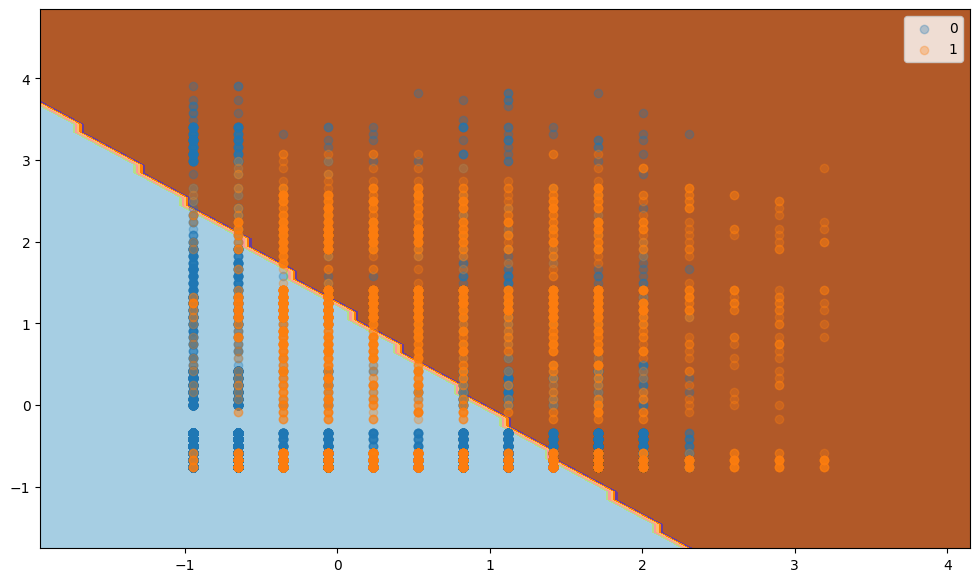


 Model: Logistic Regression - penalty:l2, parametr C:1


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


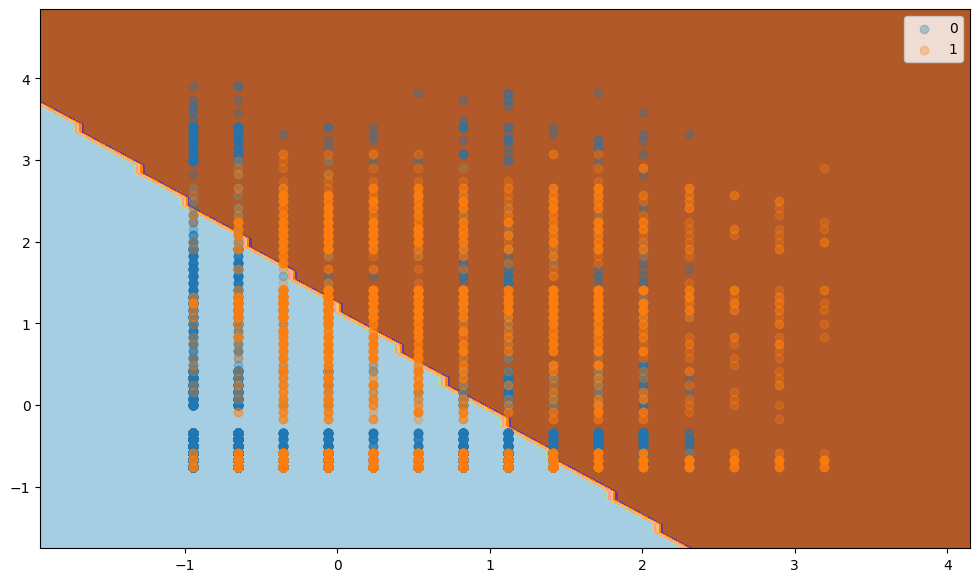


 Model: Logistic Regression - penalty:l2, parametr C:10


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


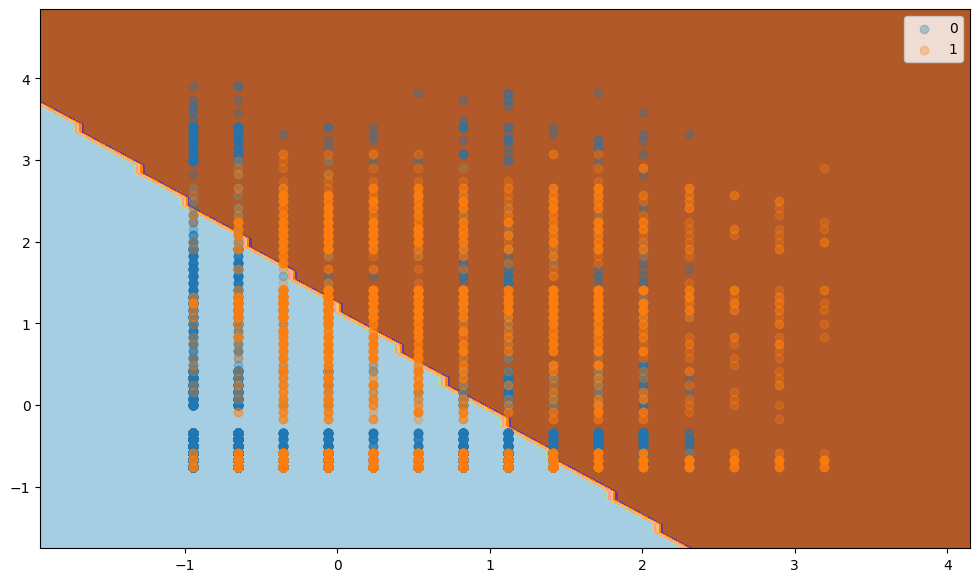


 Model: Logistic Regression - penalty:l2, parametr C:100


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


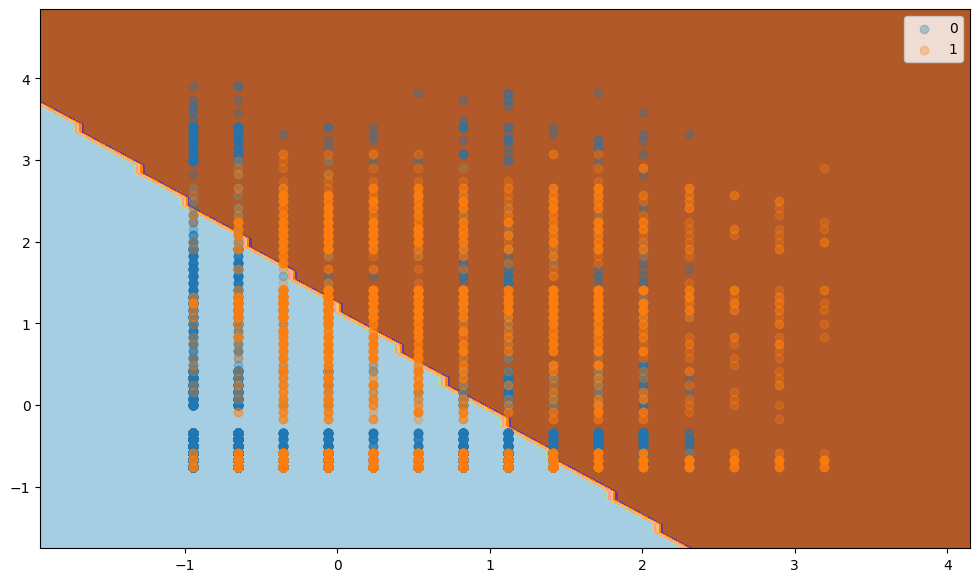


 Model: Logistic Regression - penalty:elasticnet, parametr C:0.01


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


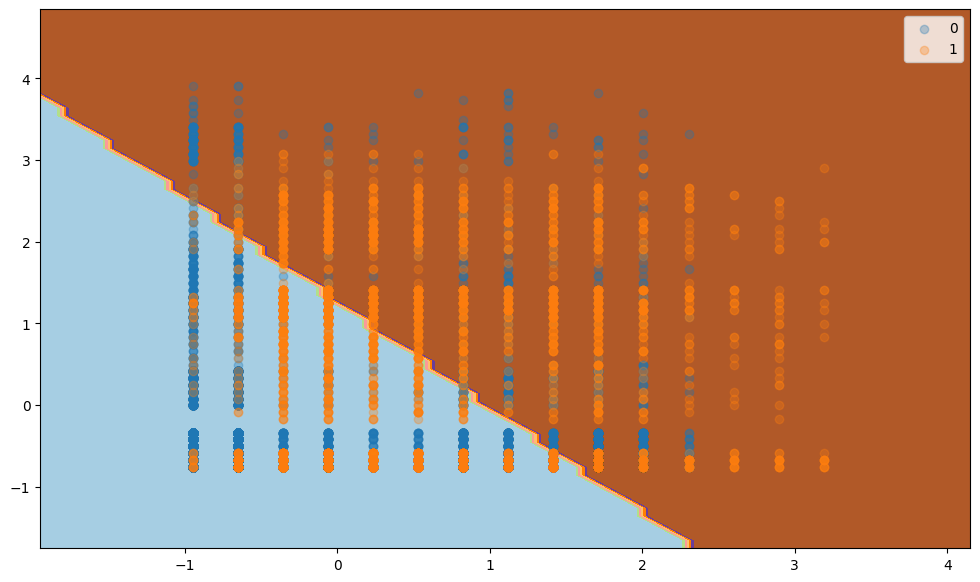


 Model: Logistic Regression - penalty:elasticnet, parametr C:0.1


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


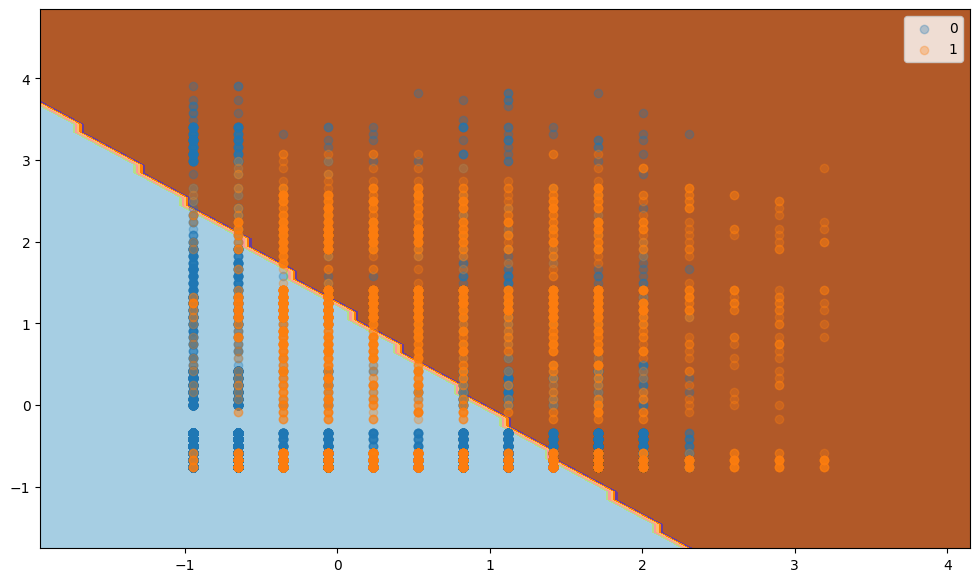


 Model: Logistic Regression - penalty:elasticnet, parametr C:1


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


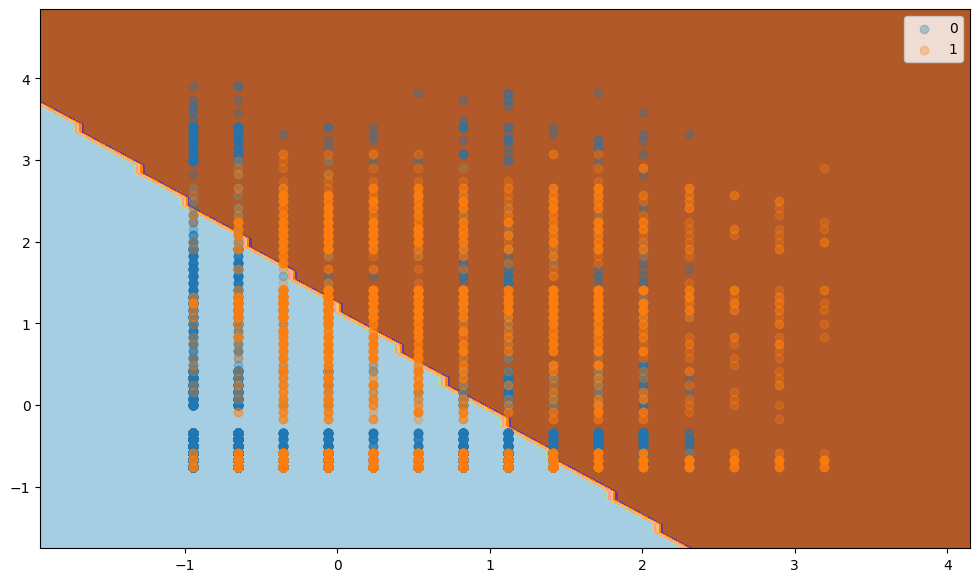

C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)



 Model: Logistic Regression - penalty:elasticnet, parametr C:10


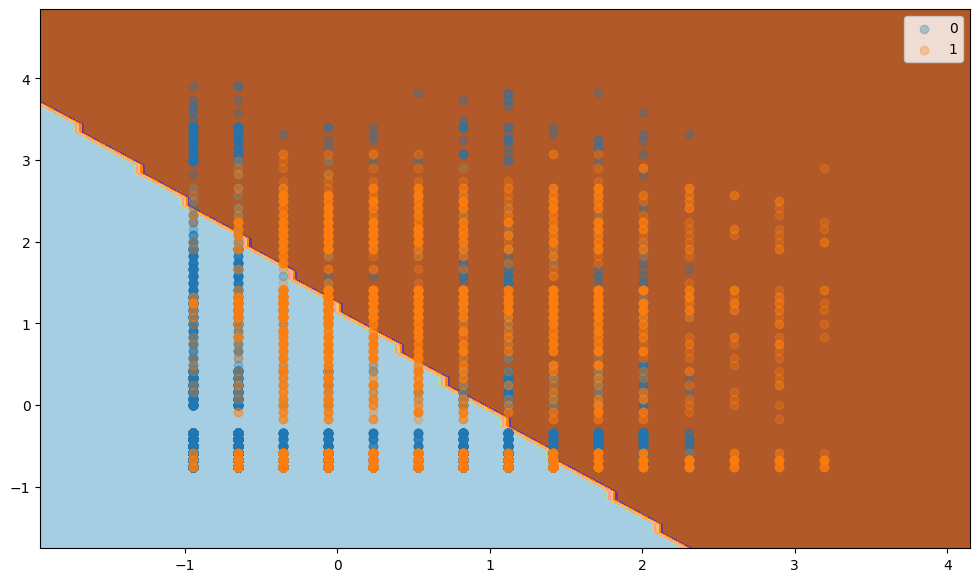


 Model: Logistic Regression - penalty:elasticnet, parametr C:100


C:\Users\marci\AppData\Local\Temp\ipykernel_26632\2011725696.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)


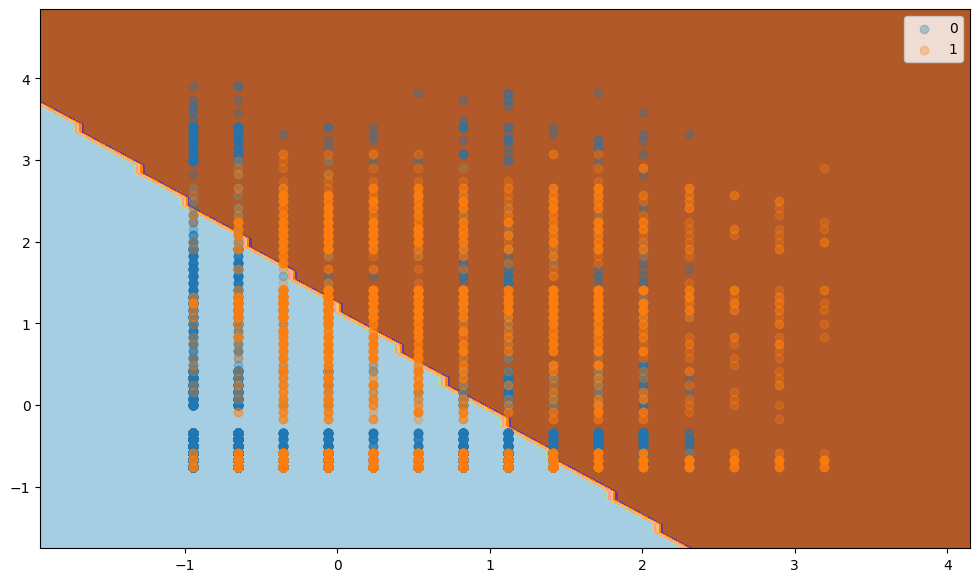

Model     Penalty   Par_C  F1_train  F1_test  AUC_test  \
0   Logistic Regression          l1    0.01    0.5464   0.5773    0.8160   
1   Logistic Regression          l1    0.10    0.5469   0.5809    0.8165   
2   Logistic Regression          l1    1.00    0.5469   0.5809    0.8165   
3   Logistic Regression          l1   10.00    0.5469   0.5809    0.8165   
4   Logistic Regression          l1  100.00    0.5469   0.5809    0.8165   
5   Logistic Regression          l2    0.01    0.5368   0.5675    0.8165   
6   Logistic Regression          l2    0.10    0.5464   0.5773    0.8165   
7   Logistic Regression          l2    1.00    0.5469   0.5809    0.8165   
8   Logistic Regression          l2   10.00    0.5469   0.5809    0.8165   
9   Logistic Regression          l2  100.00    0.5469   0.5809    0.8165   
10  Logistic Regression  elasticnet    0.01    0.5368   0.5675    0.8165   
11  Logistic Regression  elasticnet    0.10    0.5464   0.5773    0.8165   
12  Logistic Regression  elasticnet    1.00    0.5469   0.5809    0.8165   
13  Logistic Regression  elasticnet   10.00    0.5469   0.5809    0.8165   
14  Logistic Regression  elasticnet  100.00    0.5469   0.5809    0.8165   

    Accuracy_test  Precision_test  Recall_test  
0          0.7436          0.6407       0.5253  
1          0.7451          0.6427       0.5300  
2          0.7451          0.6427       0.5300  
3          0.7451          0.6427       0.5300  
4          0.7451          0.6427       0.5300  
5          0.7416          0.6417       0.5087  
6          0.7436          0.6407       0.5253  
7          0.7451          0.6427       0.5300  
8          0.7451          0.6427       0.5300  
9          0.7451          0.6427       0.5300  
10         0.7416          0.6417       0.5087  
11         0.7436          0.6407       0.5253  
12         0.7451          0.6427       0.5300  
13         0.7451          0.6427       0.5300  
14         0.7451          0.6427       0.5300

In [8]:
for penalty in penalties:
    for C in parametrs_C:
      label = f"Logistic Regression"  
      model = generate_model_LR(penalty,C)
      model.fit(X_train_standardized,y_train)
      metrics_dataframe = calculate_metrics_new(model, label, X_test_standardized, y_test, X_train_standardized, y_train)
display(metrics_dataframe)

**WNIOSKI:**

In [9]:
print("=== Podsumowanie wynik√≥w regresji logistycznej ===\n")
print(f"Rodzaje regularyzacji: {penalties}")
print(f"Zastosowane warto≈õci parametru C: {parametrs_C}\n")

print("üìä Zakresy metryk na zbiorze testowym (dla r√≥≈ºnych modeli):")
print(f" - Dok≈Çadno≈õƒá (Accuracy): {round(metrics_dataframe['Accuracy_test'].min(), 4)} ‚Äì {round(metrics_dataframe['Accuracy_test'].max(), 4)}")
print(f" - Precyzja (Precision): {round(metrics_dataframe['Precision_test'].min(), 4)} ‚Äì {round(metrics_dataframe['Precision_test'].max(), 4)}")
print(f" - Czu≈Ço≈õƒá (Recall): {round(metrics_dataframe['Recall_test'].min(), 4)} ‚Äì {round(metrics_dataframe['Recall_test'].max(), 4)}")

print("\nüìâ Og√≥lna jako≈õƒá predykcji:")
print("Modele regresji logistycznej (nawet przy zmianie regularyzacji) osiƒÖgajƒÖ podobne, raczej niskie wyniki.")
print("Wskazuje to, ≈ºe tylko dwie cechy: 'Pregnancies' i 'Age'sƒÖ prawdopodobnie niewystarczajƒÖce do skutecznego przewidywania cukrzycy.")

print("\nüìê Metryka F1 (zbalansowana ocena precyzji i czu≈Ço≈õci):")
print(f" - F1 (trening): {round(metrics_dataframe['F1_train'].min(), 4)} ‚Äì {round(metrics_dataframe['F1_train'].max(), 4)}")
print(f" - F1 (test):    {round(metrics_dataframe['F1_test'].min(), 4)} ‚Äì {round(metrics_dataframe['F1_test'].max(), 4)}")

print("\nüß† Wnioski:")
print("Ma≈Ça r√≥≈ºnicy miƒôdzy F1 na zbiorze treningowym i testowym sugeruje brak przetrenowania.")
print("Niski poziom metryk wskazuje, ≈ºe model raczej wymaga dotrenowania na wiƒôkszek ilo≈õci cech.")

=== Podsumowanie wynik√≥w regresji logistycznej ===

Rodzaje regularyzacji: ['l1', 'l2', 'elasticnet']
Zastosowane warto≈õci parametru C: [0.01, 0.1, 1, 10, 100]

üìä Zakresy metryk na zbiorze testowym (dla r√≥≈ºnych modeli):
 - Dok≈Çadno≈õƒá (Accuracy): 0.7416 ‚Äì 0.7451
 - Precyzja (Precision): 0.6407 ‚Äì 0.6427
 - Czu≈Ço≈õƒá (Recall): 0.5087 ‚Äì 0.53

üìâ Og√≥lna jako≈õƒá predykcji:
Modele regresji logistycznej (nawet przy zmianie regularyzacji) osiƒÖgajƒÖ podobne, raczej niskie wyniki.
Wskazuje to, ≈ºe tylko dwie cechy: 'Pregnancies' i 'Age'sƒÖ prawdopodobnie niewystarczajƒÖce do skutecznego przewidywania cukrzycy.

üìê Metryka F1 (zbalansowana ocena precyzji i czu≈Ço≈õci):
 - F1 (trening): 0.5368 ‚Äì 0.5469
 - F1 (test):    0.5675 ‚Äì 0.5809

üß† Wnioski:
Ma≈Ça r√≥≈ºnicy miƒôdzy F1 na zbiorze treningowym i testowym sugeruje brak przetrenowania.
Niski poziom metryk wskazuje, ≈ºe model raczej wymaga dotrenowania na wiƒôkszek ilo≈õci cech.
